In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
import numpy as np
import statistics as st
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn import linear_model,svm
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
inp= {}

In [3]:
df = pd.read_csv(r'E:\SEm 5\ML\project\weatherHistory.csv', parse_dates=['Formatted Date'])
# print(df.shape)
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None
                   Formatted Date        Summary Precip Type  Te

In [4]:
first_row_original = df.iloc[0]

In [5]:
df = df.drop_duplicates(['Formatted Date'], keep='first')
#print(df.shape)

df.sort_values(by=['Formatted Date'], inplace=True)
df.reset_index(inplace=True, drop=True)

df = df.drop(columns=['Loud Cover', 'Formatted Date'])
print(df.isnull().sum(axis=0) * 100/len(df))

Summary                     0.000000
Precip Type                 0.536146
Temperature (C)             0.000000
Apparent Temperature (C)    0.000000
Humidity                    0.000000
Wind Speed (km/h)           0.000000
Wind Bearing (degrees)      0.000000
Visibility (km)             0.000000
Pressure (millibars)        0.000000
Daily Summary               0.000000
dtype: float64


In [6]:
df = df[df['Precip Type'].notna()]

<AxesSubplot:>

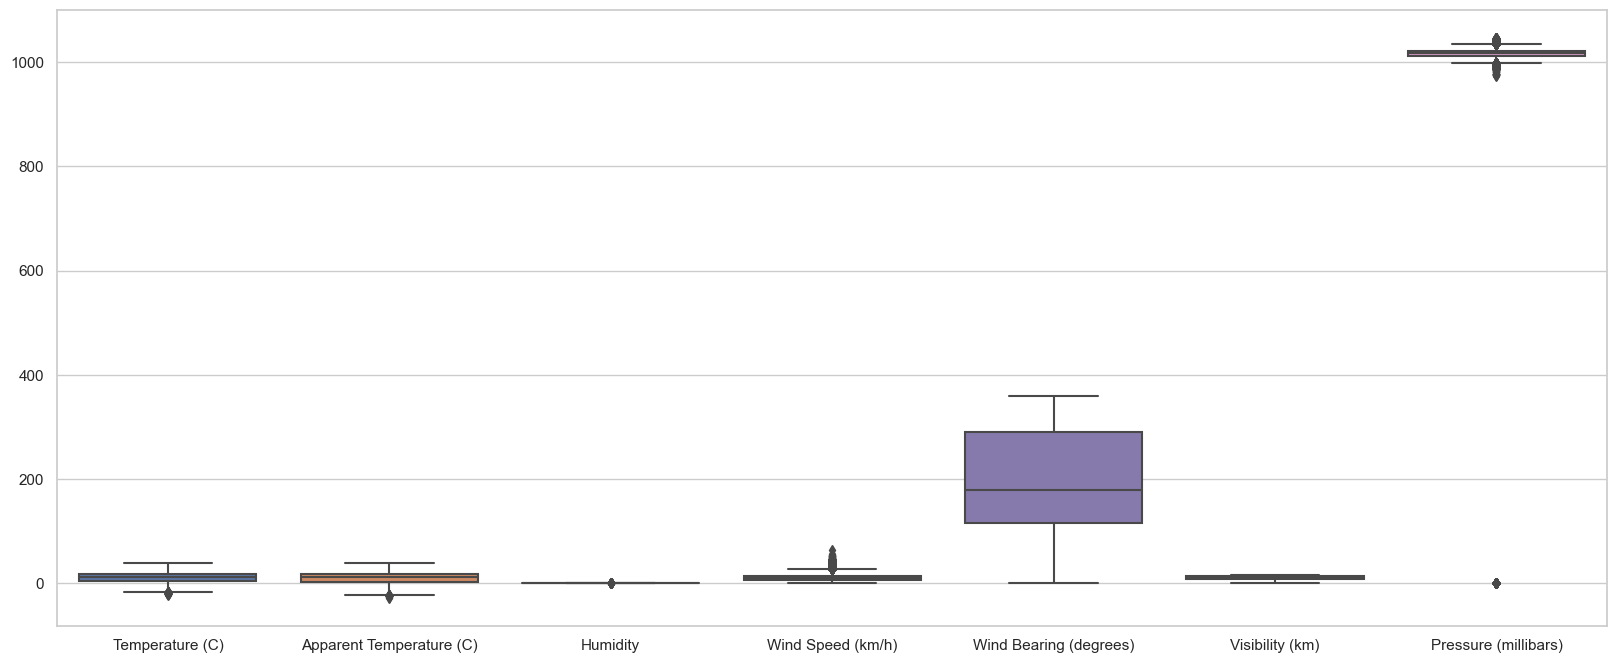

In [7]:
sns.set(rc={'figure.figsize':(20,8)}, style='whitegrid')
sns.boxplot(data=df)

In [8]:
df = df[df['Humidity'] != 0.0]
df = df[df['Wind Speed (km/h)'] <= 60]
df = df[df['Pressure (millibars)'] > 0]
df.reset_index(inplace=True, drop=True)
print(df.shape)

(94601, 10)


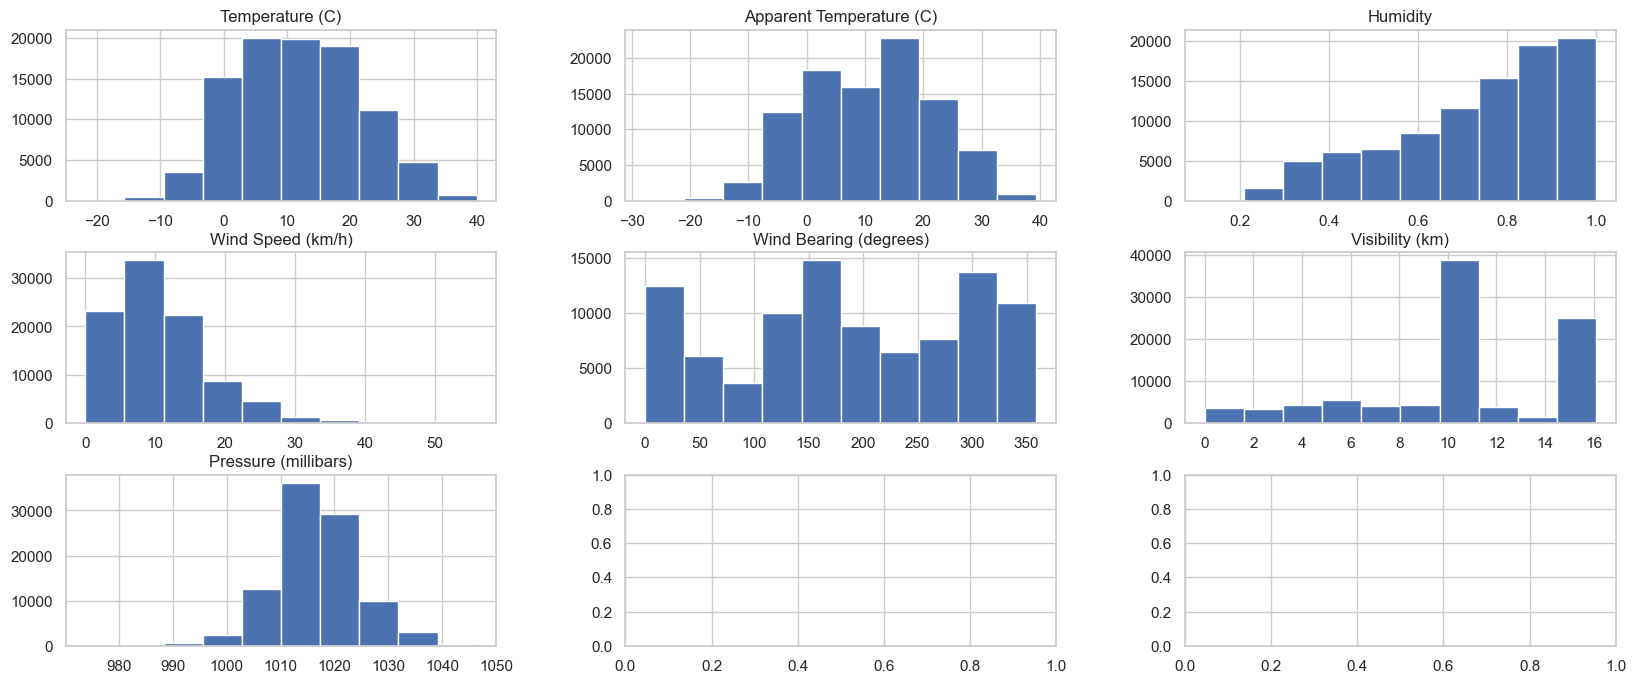

In [9]:
fig, axes = plt.subplots(3,3)
for i, column in enumerate(df.columns[2:9]):
    temp_df = pd.DataFrame(df[column], columns=[column])
    temp_df.hist(ax=axes[int(i/3)][i%3])
plt.show()

In [10]:
# squre root transformation for 'Wind Speed'
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)
data_transformed = sqrt_transformer.transform(df[['Wind Speed (km/h)']])
df['Wind Speed (km/h)'] = data_transformed
# power transformation with power of 2 for 'Humidity'
power_transformer = FunctionTransformer(lambda x: x**2, validate=True)
data_transformed = power_transformer.transform(df[['Humidity']])
df['Humidity'] = data_transformed

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [11]:
print(df.columns)
print(df)

Index(['Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)',
       'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
       'Visibility (km)', 'Pressure (millibars)', 'Daily Summary'],
      dtype='object')
             Summary Precip Type  Temperature (C)  Apparent Temperature (C)  \
0      Partly Cloudy        rain         0.577778                 -4.050000   
1      Mostly Cloudy        rain         1.161111                 -3.238889   
2      Mostly Cloudy        rain         1.666667                 -3.155556   
3           Overcast        rain         1.711111                 -2.194444   
4      Mostly Cloudy        rain         1.183333                 -2.744444   
...              ...         ...              ...                       ...   
94596  Mostly Cloudy        rain         0.488889                 -2.644444   
94597  Mostly Cloudy        rain         0.072222                 -3.050000   
94598  Mostly Cloudy        snow        -0.233333    

In [12]:
df['Precip Type'] = df['Precip Type'].astype('category').cat.codes

cols = ['Summary','Daily Summary']
inp['Apparent Temperature (C)'] = 10.88939428641989
cols_encoded = []
for col in cols:
  cols_encoded += [f"{col}_{cat}" for cat in list(df[col].unique())]


cols = ['Summary','Daily Summary']
ohe = OneHotEncoder()
ohe.fit(df[cols])
encoded_df = pd.DataFrame(ohe.transform(df[cols]).toarray(),columns= cols_encoded)
df = df.join(encoded_df)


In [13]:
# df_target = pd.DataFrame(df['Apparent Temperature (C)'], columns=['Apparent Temperature (C)'])
df_target = pd.DataFrame(df['Temperature (C)'], columns=['Temperature (C)'])
# print("2",df.shape)
df_data = df.drop('Temperature (C)', axis=1)
#df_data = df_data.drop('Apparent Temperature (C)', axis=1)
df_data = df_data.drop(cols,axis = 1)
x_train, x_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.2, random_state=23)


In [14]:
np.mean(df['Apparent Temperature (C)'])

10.889394286412287

In [15]:
std_columns = ['Humidity',
   'Wind Speed (km/h)',
   'Wind Bearing (degrees)',
   'Visibility (km)',
   'Pressure (millibars)']

# for feature data
scaler_train = StandardScaler()
scaler_train.fit(x_train[std_columns])
x_train_scaled = scaler_train.transform(x_train[std_columns])
x_test_scaled = scaler_train.transform(x_test[std_columns])
df_x_train_standardized = pd.DataFrame(x_train_scaled, columns = std_columns)
df_x_test_standardized = pd.DataFrame(x_test_scaled, columns = std_columns)
# for target data
scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train_scaled = scaler_target.transform(y_train)
y_test_scaled = scaler_target.transform(y_test)
df_y_train_standardized = pd.DataFrame(y_train_scaled, columns = ['Temperature (C)'])
df_y_test_standardized = pd.DataFrame(y_test_scaled, columns = ['Temperature (C)'])


<AxesSubplot:>

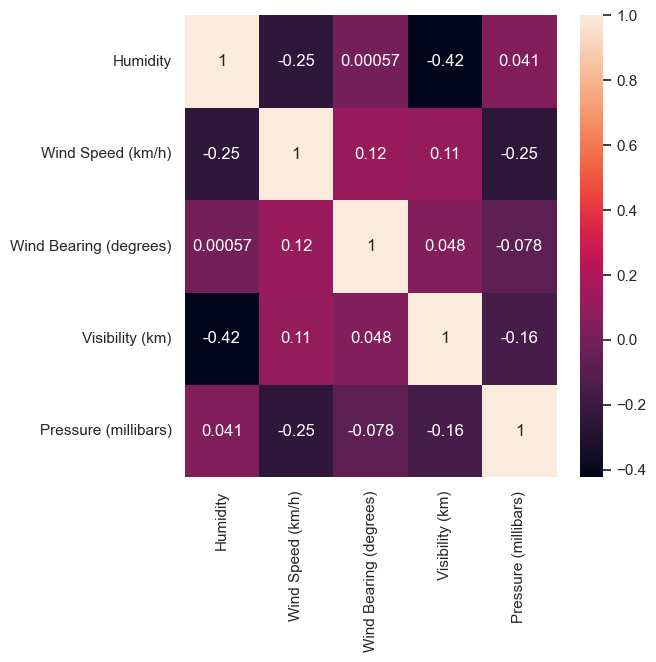

In [16]:

sns.set(rc={'figure.figsize':(6,6)})
sns.heatmap(df_x_train_standardized.corr(), annot=True)


In [17]:
x_train


,Precip Type,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Partly Cloudy,Summary_Mostly Cloudy,Summary_Overcast,...,Daily Summary_Overcast starting in the afternoon.,Daily Summary_Overcast throughout the day and breezy starting in the morning continuing until evening.,Daily Summary_Partly cloudy throughout the day and breezy in the afternoon.,Daily Summary_Light rain starting overnight.,Daily Summary_Drizzle starting in the evening.,Daily Summary_Drizzle until morning.,Daily Summary_Rain throughout the day.,Daily Summary_Rain until morning.,Daily Summary_Light rain overnight.,Daily Summary_Rain until afternoon.
41264,0,7.061111,0.7569,0.000000,0.0,7.1323,1015.97,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5976,0,15.666667,0.5476,3.311208,104.0,9.8371,1024.57,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23515,0,9.188889,0.7921,2.643369,310.0,6.1180,1014.13,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30420,0,13.888889,0.5184,3.588872,330.0,9.9820,1015.10,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20368,0,24.827778,0.1369,3.301469,22.0,11.2056,1011.67,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,0,12.266667,1.0000,3.034666,161.0,7.1323,1010.59,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9704,1,-4.077778,0.9216,2.512210,140.0,9.6761,1018.84,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76726,0,8.588889,0.6889,3.144106,140.0,9.9820,1011.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92105,0,27.100000,0.1296,2.615817,350.0,15.5526,1019.14,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
pca = TruncatedSVD(n_components=11)
pca.fit(x_train)
pca_x_train = pca.transform(x_train)
pca_x_test = pca.transform(x_test)


In [19]:
mo = ["Random Forest","PLS","Linear Regression","Lasso","SVR"]
sc = [0,0,0,0,0]

Mean squared error(Train) : 0.0073
Root mean squared error(Train) : 0.0856
Explained variance of the predictions(Train) : 99.992
Mean squared error(Testing) : 0.0511
Root mean squared error(Testing) : 0.226
Explained variance of the predictions(Testing) : 99.9445


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Predicted Apparent Temperature (C)
Feature names seen at fit time, yet now missing:
- Temperature (C)

  warnings.warn(message, FutureWarning)


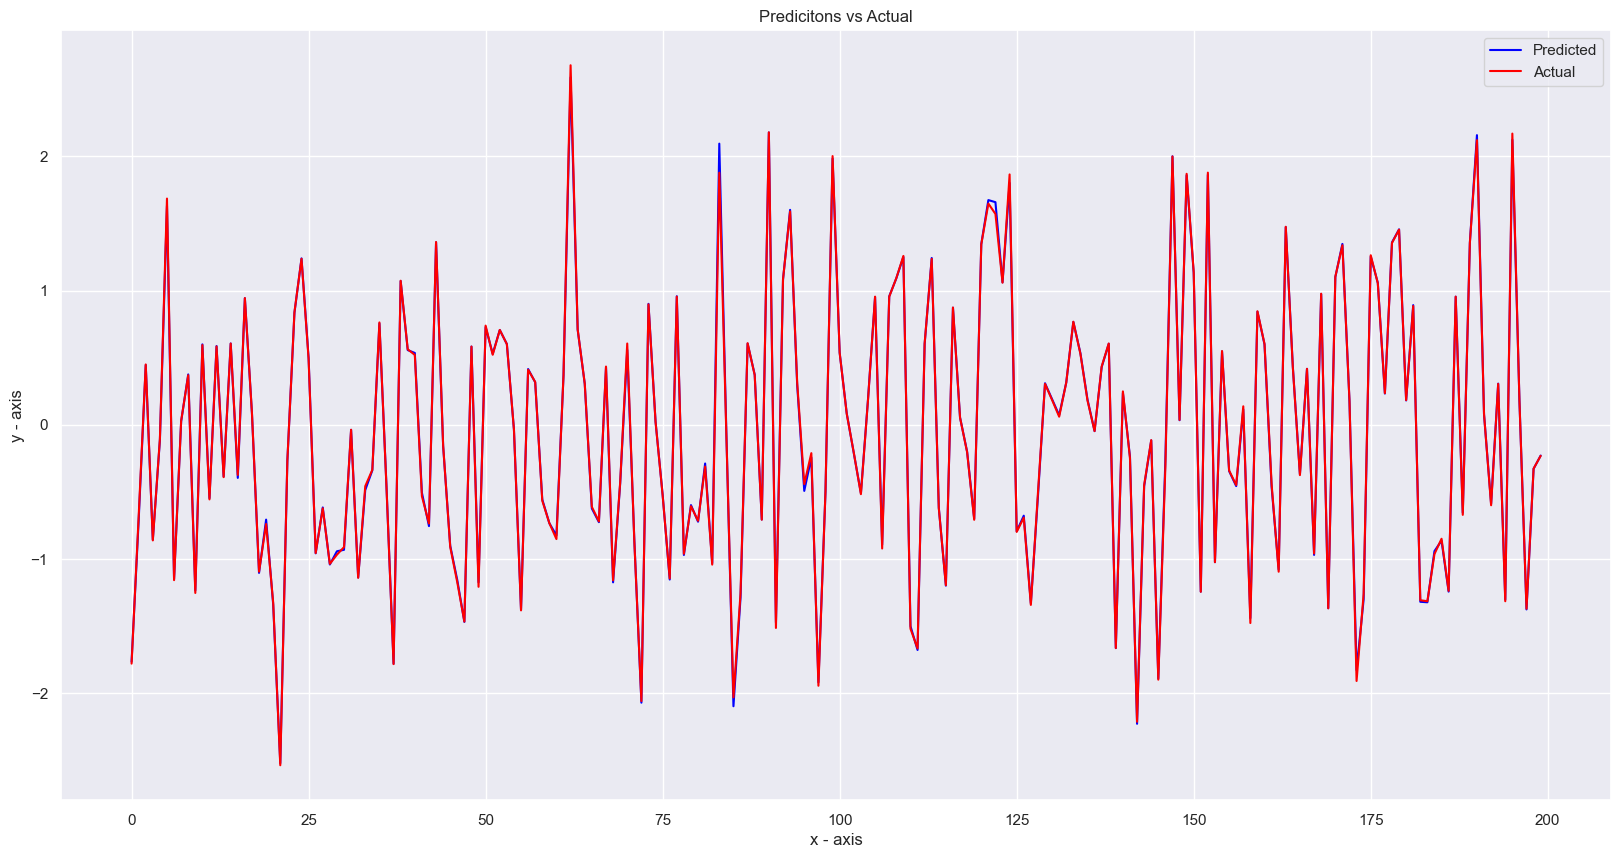

In [20]:
lm = RandomForestRegressor()
model = lm.fit(pca_x_train,y_train.values.ravel())
predictions = lm.predict(pca_x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])
# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

predictions = lm.predict(pca_x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])
# Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))
sc[0] = score
y_pred_scaled = scaler_target.transform(y_pred)
sns.set(rc={'figure.figsize':(20,10)})
plt.plot(y_pred_scaled[:200], label='Predicted', color='blue')
plt.plot(y_test_scaled[:200], label='Actual', color='red')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Predicitons vs Actual')
plt.legend()
plt.show()

Mean squared error(Train) : 0.8966
Root mean squared error(Train) : 0.9469
Explained variance of the predictions(Train) : 99.0166
Mean squared error(Testing) : 0.8875
Root mean squared error(Testing) : 0.9421
Explained variance of the predictions(Testing) : 99.0358


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Predicted Apparent Temperature (C)
Feature names seen at fit time, yet now missing:
- Temperature (C)

  warnings.warn(message, FutureWarning)


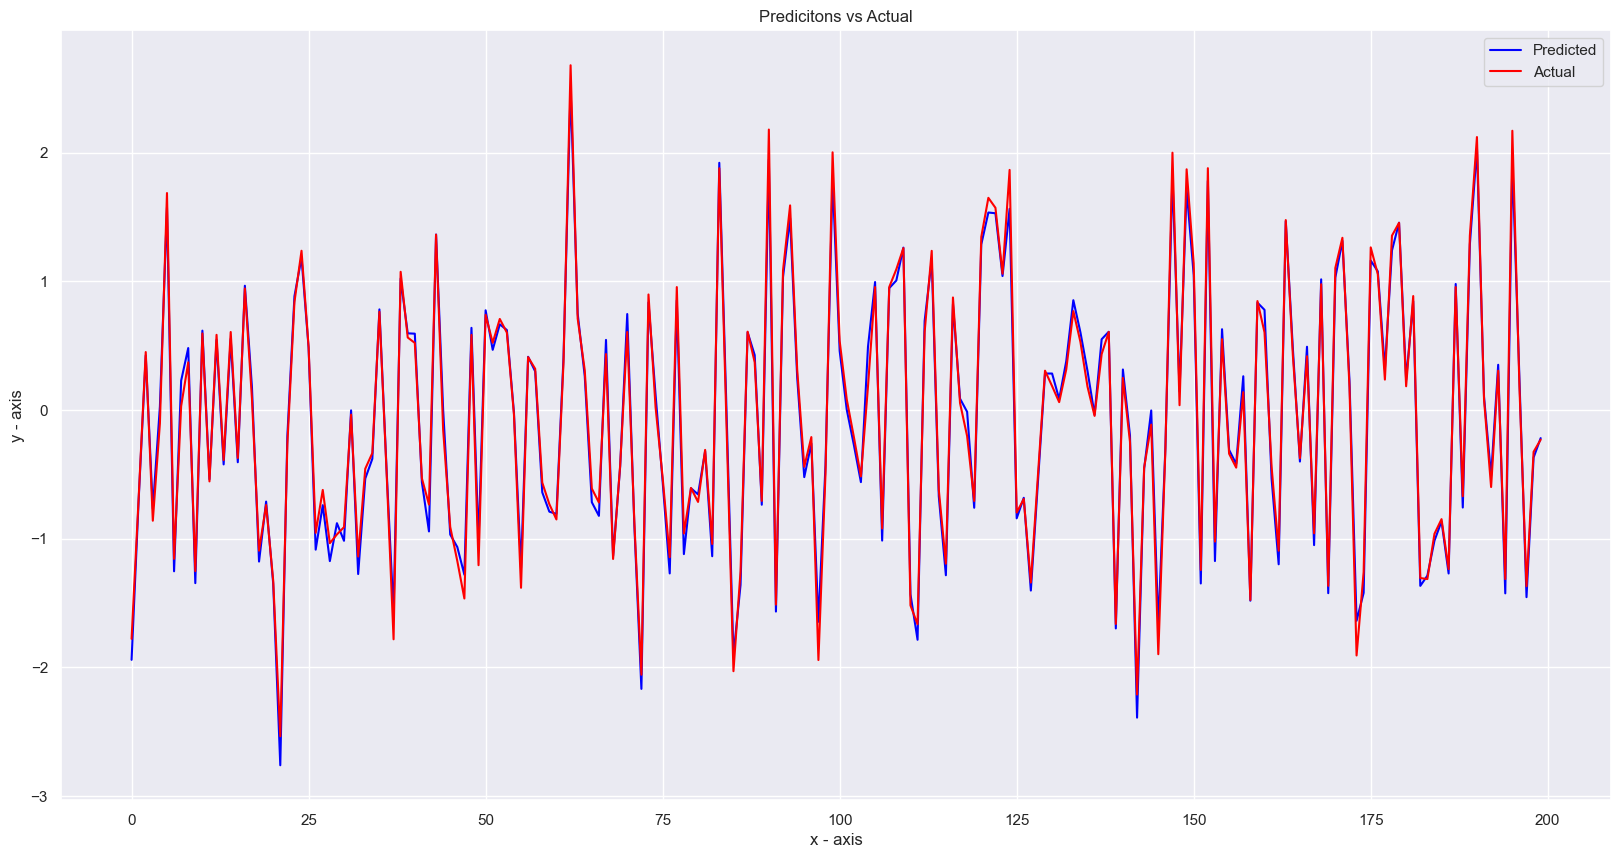

In [21]:
lm = PLSRegression()
model = lm.fit(pca_x_train,y_train)
predictions = lm.predict(pca_x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

predictions = lm.predict(pca_x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])
# Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))
sc[1] = score
y_pred_scaled = scaler_target.transform(y_pred)
sns.set(rc={'figure.figsize':(20,10)})
plt.plot(y_pred_scaled[:200], label='Predicted', color='blue')
plt.plot(y_test_scaled[:200], label='Actual', color='red')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Predicitons vs Actual')
plt.legend()
plt.show()

Mean squared error(Train) : 0.8866
Root mean squared error(Train) : 0.9416
Explained variance of the predictions(Train) : 99.0275
Mean squared error(Testing) : 0.8802
Root mean squared error(Testing) : 0.9382
Explained variance of the predictions(Testing) : 99.0437


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Predicted Apparent Temperature (C)
Feature names seen at fit time, yet now missing:
- Temperature (C)

  warnings.warn(message, FutureWarning)


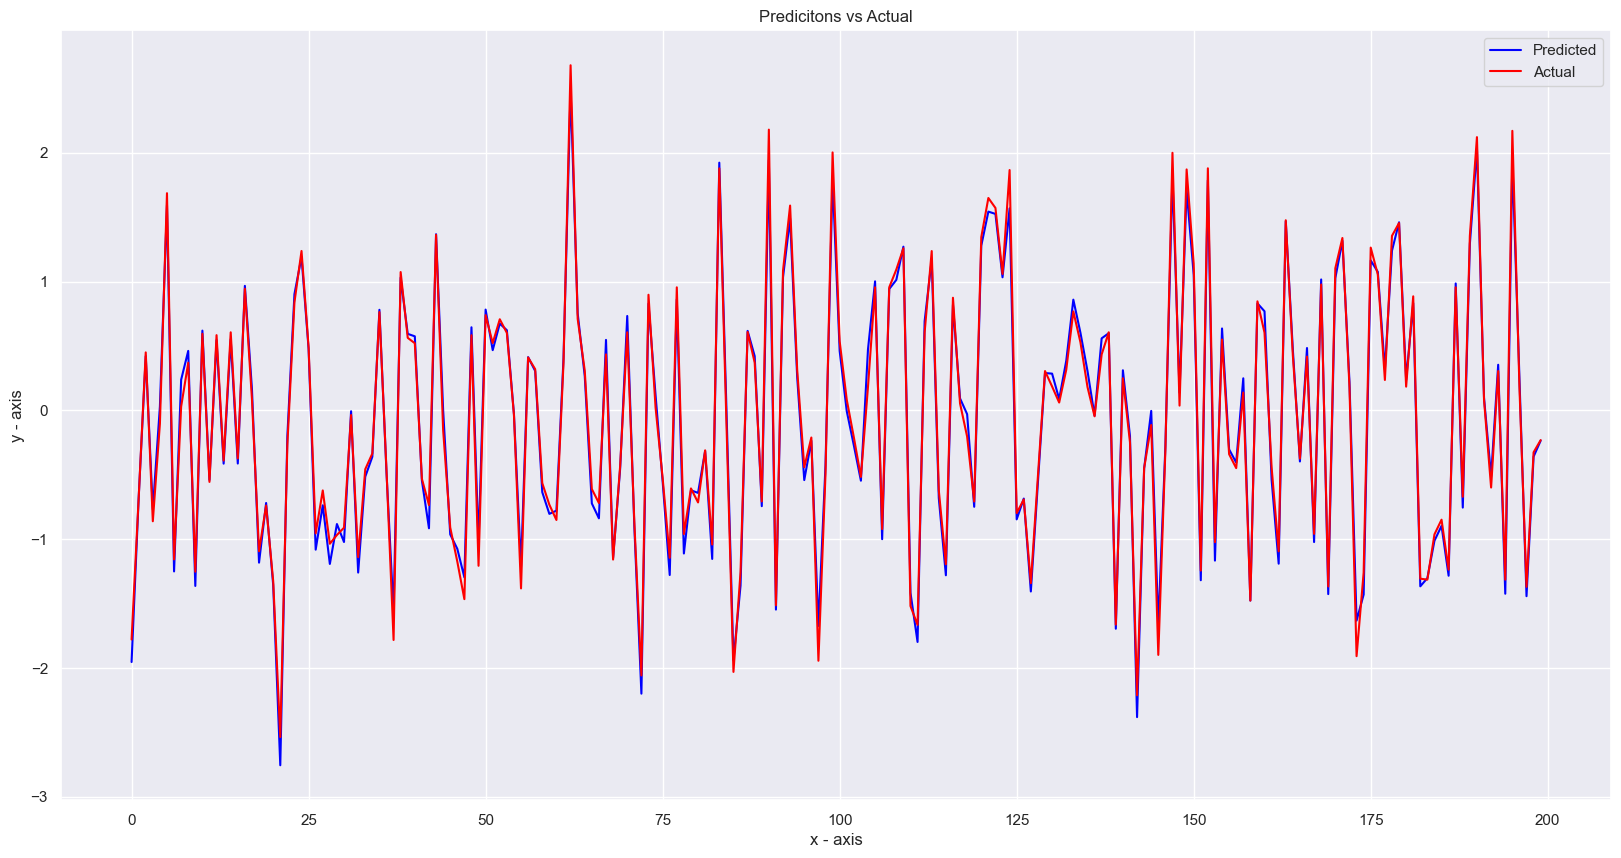

In [22]:
lm = linear_model.LinearRegression()
model = lm.fit(pca_x_train, y_train)
predictions = lm.predict(pca_x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

predictions = lm.predict(pca_x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])
# Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))
sc[2] = score
y_pred_scaled = scaler_target.transform(y_pred)
sns.set(rc={'figure.figsize':(20,10)})
plt.plot(y_pred_scaled[:200], label='Predicted', color='blue')
plt.plot(y_test_scaled[:200], label='Actual', color='red')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Predicitons vs Actual')
plt.legend()
plt.show()

Mean squared error(Train) : 0.8866
Root mean squared error(Train) : 0.9416
Explained variance of the predictions(Train) : 99.0275
Mean squared error(Testing) : 0.8803
Root mean squared error(Testing) : 0.9382
Explained variance of the predictions(Testing) : 99.0436


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Predicted Apparent Temperature (C)
Feature names seen at fit time, yet now missing:
- Temperature (C)

  warnings.warn(message, FutureWarning)


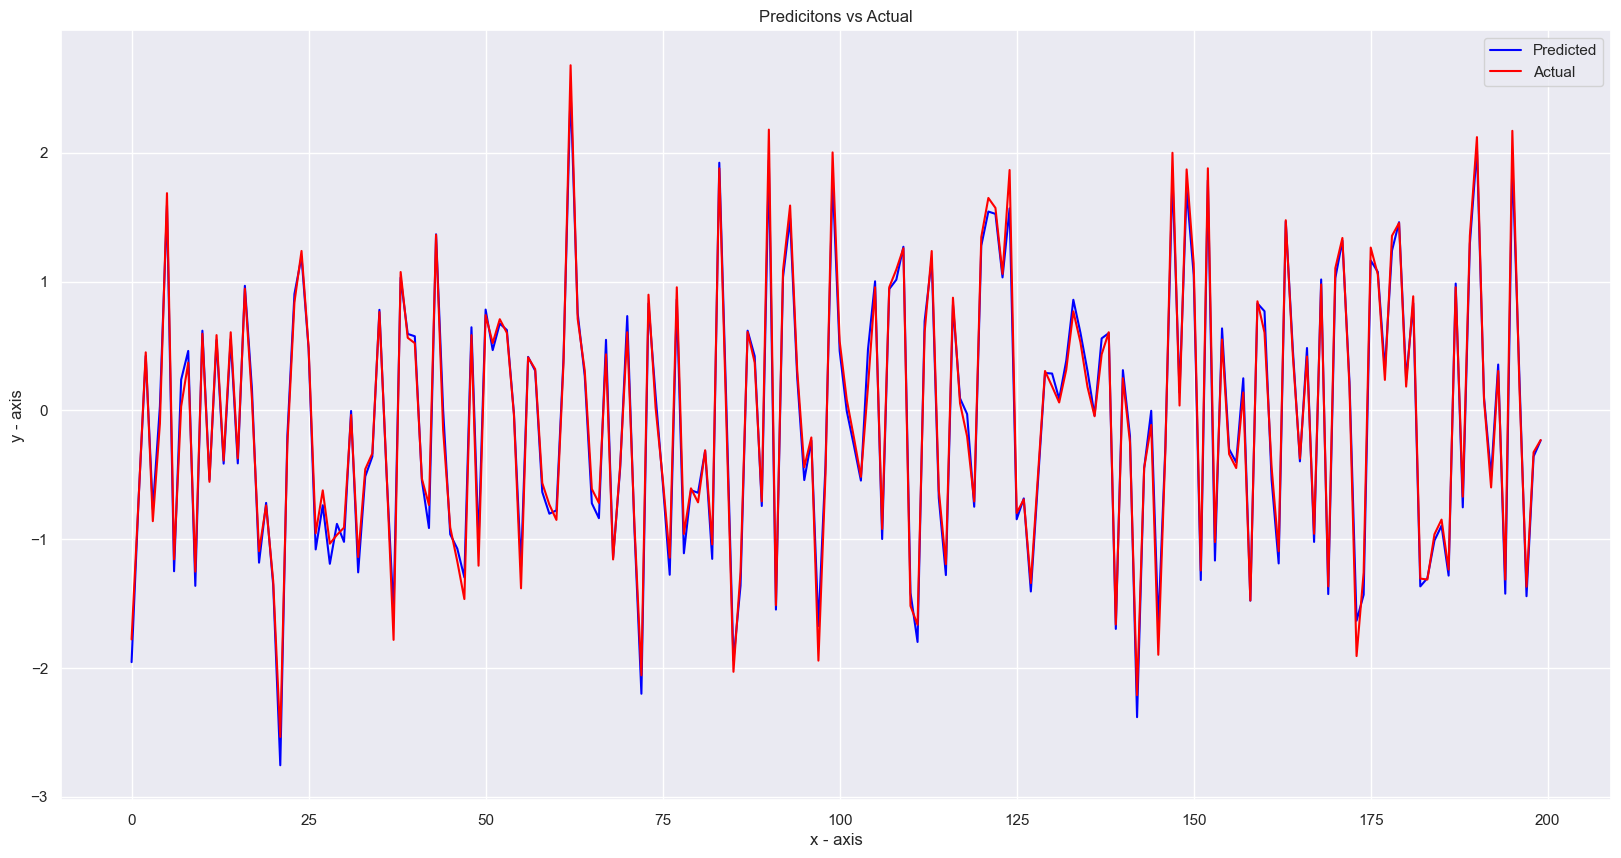

In [23]:
lm = linear_model.Lasso(0.001)
lm = lm.fit(pca_x_train,y_train)
predictions = lm.predict(pca_x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

predictions = lm.predict(pca_x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])
# Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))
sc[3] = score
y_pred_scaled = scaler_target.transform(y_pred)
sns.set(rc={'figure.figsize':(20,10)})
plt.plot(y_pred_scaled[:200], label='Predicted', color='blue')
plt.plot(y_test_scaled[:200], label='Actual', color='red')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Predicitons vs Actual')
plt.legend()
plt.show()

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Predicted Apparent Temperature (C)
Feature names seen at fit time, yet now missing:
- Temperature (C)

  warnings.warn(message, FutureWarning)


Mean squared error(Train) : 0.9951
Root mean squared error(Train) : 0.9975
Explained variance of the predictions(Train) : 98.9085
Mean squared error(Testing) : 0.9857
Root mean squared error(Testing) : 0.9928
Explained variance of the predictions(Testing) : 98.9291


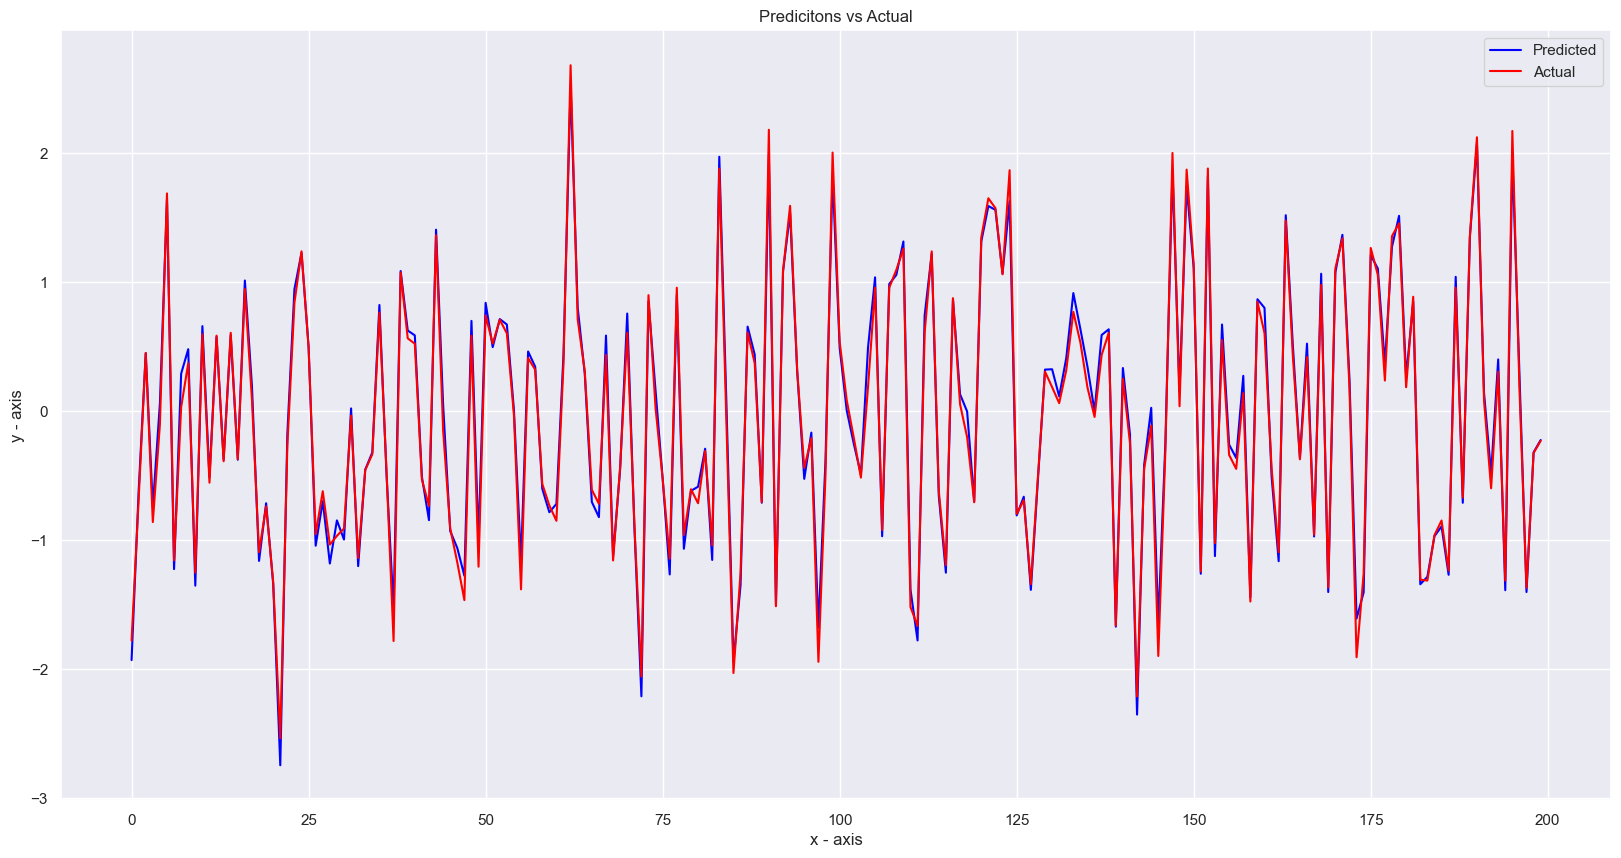

In [24]:
lm = svm.LinearSVR(C = 1.0, epsilon=0.2)
model = lm.fit(pca_x_train,y_train.values.ravel())
predictions = lm.predict(pca_x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

predictions = lm.predict(pca_x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])
# Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))
sc[4] = score
y_pred_scaled = scaler_target.transform(y_pred)
sns.set(rc={'figure.figsize':(20,10)})
plt.plot(y_pred_scaled[:200], label='Predicted', color='blue')
plt.plot(y_test_scaled[:200], label='Actual', color='red')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Predicitons vs Actual')
plt.legend()
plt.show()

In [28]:
print("ENTER Humidity")
inp['Humidity'] = float(input())

print("ENTER Visibility")
inp['Visibility (km)'] = float(input())

print("ENTER Wind Speed")
inp['Wind Speed (km/h)'] = float(input())

print("ENTER Wind Bearing")
inp['Wind Bearing (degrees)'] = int(input())

print("ENTER Pressure")
inp['Pressure (millibars)'] = float(input())

print("ENTER Precipitation Type")
inp['Precip Type'] = int(input())

print("ENTER Daily Summary")
inp['Daily Summary']=input()

print("ENTER Summary")
inp['Summary']=input()


da = sqrt_transformer.transform(np.array(inp['Wind Speed (km/h)']).reshape(-1,1))
inp['Wind Speed (km/h)'] = da

d = power_transformer.transform(np.array(inp['Humidity']).reshape(-1,1))
inp['Humidity'] = d
inp['Humidity']=np.array(inp['Humidity']).reshape(1,-1)
inp['Wind Speed (km/h)']=np.array(inp['Wind Speed (km/h)']).reshape(1,-1)

In = [inp]
data = pd.DataFrame(In)

data = data.loc[:,['Summary', 'Precip Type', 'Apparent Temperature (C)','Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
                   'Visibility (km)', 'Pressure (millibars)', 'Daily Summary']]
data_scaled = scaler_train.transform(data[std_columns])

data['Precip Type'] = data['Precip Type'].astype('category').cat.codes

encoded_data = pd.DataFrame(ohe.transform(data[cols]).toarray(),columns= cols_encoded)
data = data.join(encoded_data)
data = data.drop(cols,axis = 1)

data = pca.transform(data)

res = lm.predict(data)
print(" ")
print("predicted Temperature: ",res)

ENTER Humidity
ENTER Visibility
ENTER Wind Speed
ENTER Wind Bearing
ENTER Pressure
ENTER Precipitation Type
ENTER Daily Summary
ENTER Summary
 
predicted Temperature:  [12.6790943]


In [29]:
#plt.plot(mo,sc)
print(first_row_original)
print(df.iloc[0])

Formatted Date                      2006-04-01 00:00:00+02:00
Summary                                         Partly Cloudy
Precip Type                                              rain
Temperature (C)                                      9.472222
Apparent Temperature (C)                             7.388889
Humidity                                                 0.89
Wind Speed (km/h)                                     14.1197
Wind Bearing (degrees)                                  251.0
Visibility (km)                                       15.8263
Loud Cover                                                0.0
Pressure (millibars)                                  1015.13
Daily Summary               Partly cloudy throughout the day.
Name: 0, dtype: object
Summary                                   Partly Cloudy
Precip Type                                           0
Temperature (C)                                0.577778
Apparent Temperature (C)                          -4.05
Humidity 